#<h1><font color="#110068" size=5> TFE</font></h1>


<h1><font color="#110068" size=6>Modelo de redes convolucionales para la detección de Patologías oculares mediante el procesamiento de imágenes </font></h1>

<div style="text-align: right">
<font size=3> </font><br>
ALUMNO 1: Margarita Cardenas  </font><br>
ALUMNO 2: Miguel Rojas </font><br>
ALUMNO 3: Walter Vega </font><br>

</font><br>
<font size=3>TFE:
Implementar una Inteligencia Artificial para la detección de patologías oculares mediante el procesamiento de imágenes
</font><br>
<font size=3>UNIR</font>
</div>

# Instalación de complementos y librerias necesarias

In [1]:
!pip install pydrive2

## Descargamos el dataset de imágenes (Desde una carpeta compartida en GoogleDrive) y descomprimimos el conjunto de imágenes con los que vamos a trabajar

In [2]:
import os

from pydrive2.auth import GoogleAuth
from google.colab import drive as colab_drive
from pydrive2.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import os

# Autenticar el usuario
auth.authenticate_user()

# Inicializar GoogleAuth y establecer las credenciales
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()

# Crear la instancia de GoogleDrive
drive = GoogleDrive(gauth)

file_id = '1KXCIri7VEdjwCnTPocehAf73z_7jgbgF'

if (not os.path.exists("/content/DS_TFE_final.zip")):
  download = drive.CreateFile({'id': file_id})
  # Download the file to a local disc
  download.GetContentFile('DS_TFE_final.zip')
  !unzip "/content/DS_TFE_final.zip"


Se han truncado las últimas 5000 líneas del flujo de salida.
  inflating: DS_TFE_Final/train/Diabetic_Retinopathy/DR273.jpg  
  inflating: DS_TFE_Final/train/Diabetic_Retinopathy/DR274.jpg  
  inflating: DS_TFE_Final/train/Diabetic_Retinopathy/DR275.jpg  
  inflating: DS_TFE_Final/train/Diabetic_Retinopathy/DR277.jpg  
  inflating: DS_TFE_Final/train/Diabetic_Retinopathy/DR278.jpg  
  inflating: DS_TFE_Final/train/Diabetic_Retinopathy/DR280.jpg  
  inflating: DS_TFE_Final/train/Diabetic_Retinopathy/DR281.jpg  
  inflating: DS_TFE_Final/train/Diabetic_Retinopathy/DR282.jpg  
  inflating: DS_TFE_Final/train/Diabetic_Retinopathy/DR283.jpg  
  inflating: DS_TFE_Final/train/Diabetic_Retinopathy/DR286.jpg  
  inflating: DS_TFE_Final/train/Diabetic_Retinopathy/DR288.jpg  
  inflating: DS_TFE_Final/train/Diabetic_Retinopathy/DR289.jpg  
  inflating: DS_TFE_Final/train/Diabetic_Retinopathy/DR29.jpg  
  inflating: DS_TFE_Final/train/Diabetic_Retinopathy/DR290.jpg  
  inflating: DS_TFE_Final/trai

# Importamos las librerias necesarias para los experimentos

In [3]:
import pandas
import numpy as np
import os
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2
import glob

from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

Ejemplo de salida de una imágen luego de aplicada la transformación Heatmap

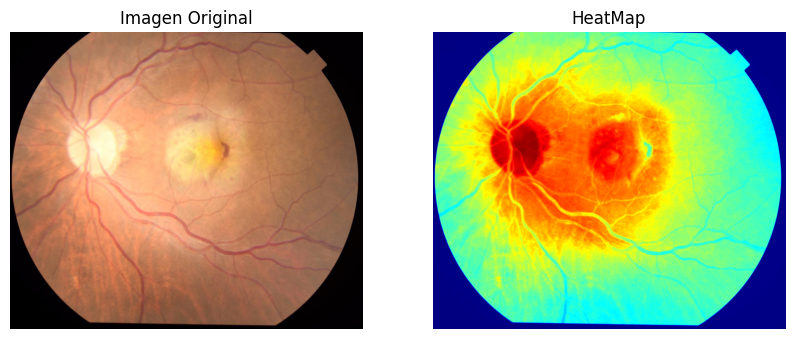

In [ ]:
from tensorflow.keras.applications.resnet50 import preprocess_input
from skimage import exposure

image_path = '/content/DS_TFE_Final/test/Macular_Scar/Macular Scar125-flip.jpg'
image = cv2.imread(image_path)

    # Verificar el tipo de la imagen
if image.dtype != np.uint8:
    # Normalizar la imagen a rango 0-255
    image = (255 * (image - np.min(image)) / (np.max(image) - np.min(image))).astype(np.uint8)

# Convertir la imagen a escala de grises si es necesario
if len(image.shape) == 3 and image.shape[2] == 3:
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
elif len(image.shape) == 2:
    gray_image = image
else:
    raise ValueError("Formato de imagen no soportado")

# Aplicar un colormap (heatmap)
heatmap_image = cv2.applyColorMap(gray_image, cv2.COLORMAP_JET)

# Mostrar la imagen original y la imagen con heatmap
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.title('Imagen Original')
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title('HeatMap')
plt.imshow(cv2.cvtColor(heatmap_image, cv2.COLOR_BGR2RGB))
plt.axis('off')

plt.show()


Carga de las variables con los directores donde se encuentran las imágenes de entrenamiento, validación y prueba

In [4]:
train_dir = '/content/DS_TFE_Final/train'
test_dir = '/content/DS_TFE_Final/test'
val_dir = '/content/DS_TFE_Final/val'

Función para convertir la imágen aplicando el filtro HeatMap.
Esta función se ejecuta al momento de procesar las imagenes en el entrenamiento mediante el ImageDataGenerator

In [5]:
from tensorflow.keras.applications.resnet50 import preprocess_input
from skimage import exposure

def preprocessing_image(image):
        # Verificar el tipo de la imagen
    if image.dtype != np.uint8:
        # Normalizar la imagen a rango 0-255
        image = (255 * (image - np.min(image)) / (np.max(image) - np.min(image))).astype(np.uint8)

    # Convertir la imagen a escala de grises si es necesario
    if len(image.shape) == 3 and image.shape[2] == 3:
        gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    elif len(image.shape) == 2:
        gray_image = image
    else:
        raise ValueError("Formato de imagen no soportado")

    # Aplicar un colormap (heatmap)
    heatmap_image = cv2.applyColorMap(gray_image, cv2.COLORMAP_JET)

    # Redimensionar la imagen al tamaño esperado por el modelo
    heatmap_image_resized = cv2.resize(heatmap_image, (224, 224))

    # Preprocesar la imagen para ResNet50V2
    heatmap_image_preprocessed = preprocess_input(heatmap_image_resized)

    return heatmap_image_preprocessed

## Creación de los generadores de imágenes mediante el objeto ImageDataGenerator

Este objeto permite procesar batches con una cantidad determinada de imágenes con normalización X/255, desde los directorios definidos anteriormente.

El batch definido es de 20 y al tratarse de un algoritmo de clasificación multiclase se utiliza el parámetro class_mode como categorical.

Adicionalmente se define el tamaño de las imagenes a procesar como (224,224)

El input_shape para el modelo indica el largo y ancho de las imagenes así como también la cantidad de dimensiones.
En este caso se ajusta a los modelos pre entrenados donde la mayoría acepta tamaños de 224,224 de 3 dimensiones (correspondiente a los canales RGB)
En algunas de las redes esta variable se debe redefinir para el tamaño correcto para diche red preentrenada



In [6]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255., preprocessing_function=preprocessing_image)
val_datagen = ImageDataGenerator(rescale = 1./255., preprocessing_function=preprocessing_image)
test_datagen = ImageDataGenerator(rescale = 1./255., preprocessing_function=preprocessing_image)


train_generator = train_datagen.flow_from_directory(train_dir, batch_size=20, class_mode='categorical', target_size = (224, 224))
validation_generator = val_datagen.flow_from_directory(val_dir, shuffle=False, batch_size=20, class_mode = 'categorical', target_size=(224, 224))
test_generator = test_datagen.flow_from_directory(test_dir, batch_size=20, class_mode = 'categorical', target_size=(224, 224))

input_shape = (224, 224, 3)

Found 5432 images belonging to 6 classes.
Found 775 images belonging to 6 classes.
Found 1554 images belonging to 6 classes.


## Preparamos la configuración para todos los graficos que vamos a utilizar

La siguiente función permite graficar los valores de accuracy, perdida, recall y auc

In [7]:
def graph(h):
    accuracy = h.history['accuracy']
    val_accuracy  = h.history['val_accuracy']

    loss = h.history['loss']
    val_loss = h.history['val_loss']

    precision = h.history['precision']
    val_precision = h.history['val_precision']

    recall = h.history['recall']
    val_recall = h.history['val_recall']

    auc = h.history['auc']
    val_auc = h.history['val_auc']

    plt.figure(figsize=(12,12))

    plt.subplot(4, 4, 1)
    plt.plot(accuracy, label = "Training accuracy")
    plt.plot(val_accuracy, label="Validation accuracy")
    plt.ylim(0, 1)
    plt.legend()
    plt.title("Training vs validation accuracy")


    plt.subplot(4,4,2)
    plt.plot(loss, label = "Training loss")
    plt.plot(val_loss, label="Validation loss")
    plt.ylim(0, 1.05)
    plt.legend()
    plt.title("Training vs validation loss")

    plt.subplot(4,4,3)
    plt.plot(precision, label = "Training Precisión")
    plt.plot(val_precision, label="Validation Precisión")
    plt.ylim(0, 1.05)
    plt.legend()
    plt.title("Training vs validation Precisión")

    plt.subplot(4,4,4)
    plt.plot(recall, label = "Training Recall")
    plt.plot(val_recall, label="Validation Recall")
    plt.ylim(0, 1.05)
    plt.legend()
    plt.title("Training vs validation Recall")

    plt.show()

    plt.figure(figsize=(12,12))

    plt.subplot(4,4,1)
    plt.plot(auc, label = "Training auc")
    plt.plot(val_auc, label="Validation auc")
    plt.ylim(0, 1.05)
    plt.legend()
    plt.title("Training vs validation auc")

    plt.show()

La siguiente función permite visualizar la matriz de confusión de una forma visualmente amigable

In [8]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns
def cf_matrix(y_pred_test, y_test, y_pred_val, y_val):
  y_true_test = y_test
  y_pred_test_classes = np.argmax(y_pred_test, axis=1)

  y_true_val = y_val
  y_pred_val_classes = np.argmax(y_pred_val, axis=1)

# Create a confusion matrix
  cm_test = confusion_matrix(y_test, y_pred_test_classes)
  cm_val = confusion_matrix(y_val, y_pred_val_classes)
  Etq = ["Cataract", "D_Retinopathy", "Glaucoma", "Healthy", "M_Scar", "Myopia"]

# Plot the confusion matrix
  plt.rcParams["figure.figsize"] = [9.50, 4.50]
  plt.rcParams["figure.autolayout"] = True

  fig, (ax1, ax2) = plt.subplots(ncols=2)
  fig.subplots_adjust(wspace=0.01)
  ax1.set_title('Confusion Matrix - Test')
  sns.heatmap(cm_test, annot=True,fmt='d', cmap='YlGnBu', ax=ax1, xticklabels=Etq, yticklabels=Etq)
  ax2.set_title('Confusion Matrix - Val')
  sns.heatmap(cm_val, annot=True,fmt='d', cmap='YlGnBu', ax=ax2, xticklabels=Etq, yticklabels=Etq)

  fig.subplots_adjust(wspace=1)
  plt.xlabel('Predicción')
  plt.ylabel('Real')
  plt.show()


La siguiente función permite calcular las métricas del modelo en función de los datos reales y las predicciones.

In [9]:
from sklearn.metrics import classification_report
def calcular_metricas_por_clase(y_pred, y):
    y_pred_classes = np.argmax(y_pred, axis=1)

    # Generar el reporte de clasificación
    reporte = classification_report(y, y_pred_classes)
    return reporte



La siguiente función permite evaluar el modelo utilizando el método evaluate propio de la librería

In [10]:
def evaluar_modelo(modelo):
  print("Evaluar con Entrenamiento:")
  modelo.evaluate(train_generator)
  print("Evaluar con Validación:")
  modelo.evaluate(test_generator)
  print("Evaluar con Prueba:")
  modelo.evaluate(validation_generator)

# Definición de Modelos

## Modelo 1

In [ ]:
# Cargar DenseNet201 sin la capa superior (top) para permitir una nueva capa de salida personalizada
base_model1 = DenseNet201(include_top=False, weights='imagenet', input_shape=(224, 224, 3))

# Congelar los pesos del modelo base para evitar que se modifiquen durante el entrenamiento inicial
for layer in base_model1.layers:
    layer.trainable = False

model1 = Sequential()
model1.add(base_model1)
model1.add(GlobalAveragePooling2D())
model1.add(Dense(128, activation = 'relu'))
model1.add(Dense(6, activation='softmax'))


# Compilar el modelo
model1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', tf.keras.metrics.Precision(name="precision"), tf.keras.metrics.Recall(name="recall"), tf.keras.metrics.AUC(name="auc")])
callback = tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=4)

history1 = model1.fit(train_generator, validation_data=test_generator, steps_per_epoch = 100, epochs=20, callbacks=callback)

Epoch 1/20
100/100 [==============================] - 83s 713ms/step - loss: 1.1273 - accuracy: 0.5557 - precision: 0.7620 - recall: 0.3599 - auc: 0.8680 - val_loss: 0.8571 - val_accuracy: 0.6577 - val_precision: 0.7666 - val_recall: 0.4968 - val_auc: 0.9265
Epoch 2/20
100/100 [==============================] - 76s 767ms/step - loss: 0.8385 - accuracy: 0.6710 - precision: 0.7669 - recall: 0.5495 - auc: 0.9292 - val_loss: 0.7486 - val_accuracy: 0.7124 - val_precision: 0.7993 - val_recall: 0.5972 - val_auc: 0.9441
Epoch 3/20
100/100 [==============================] - 67s 668ms/step - loss: 0.7305 - accuracy: 0.7290 - precision: 0.8071 - recall: 0.6295 - auc: 0.9462 - val_loss: 0.6623 - val_accuracy: 0.7465 - val_precision: 0.8180 - val_recall: 0.6480 - val_auc: 0.9566
Epoch 4/20
100/100 [==============================] - 64s 645ms/step - loss: 0.6595 - accuracy: 0.7475 - precision: 0.8134 - recall: 0.6605 - auc: 0.9561 - val_loss: 0.6500 - val_accuracy: 0.7497 - val_precision: 0.8195 - v

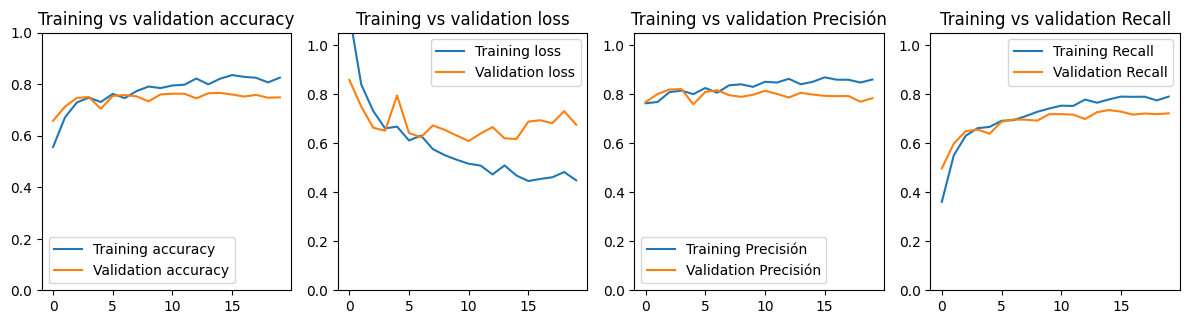

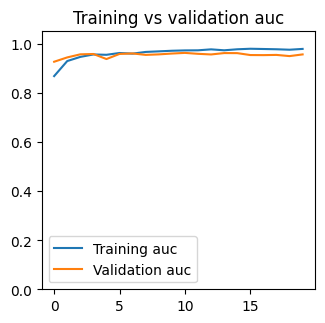

In [ ]:
graph(history1)

39/39 [==============================] - 14s 363ms/step


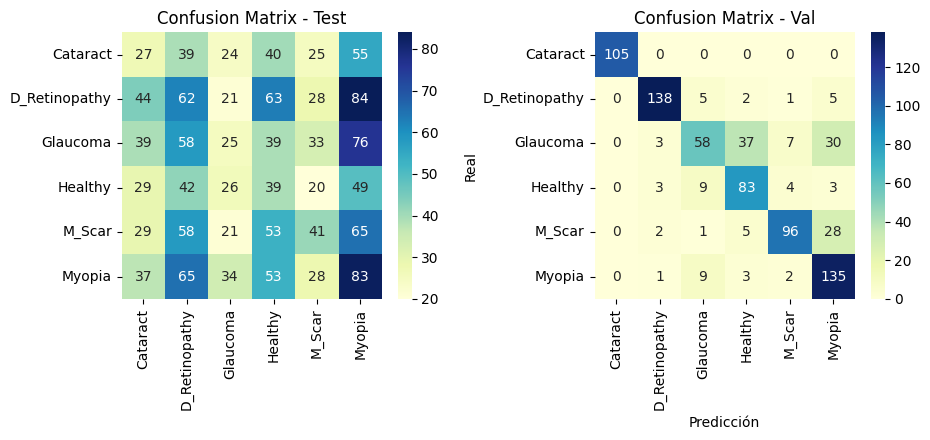

In [ ]:
y_pred1_test = model1.predict(test_generator)
y_pred1_val = model1.predict(validation_generator)
cf_matrix(y_pred1_test, test_generator.classes, y_pred1_val, validation_generator.classes)

In [ ]:
reporte = calcular_metricas_por_clase(y_pred1_test, test_generator.classes)
print(reporte)
reporte = calcular_metricas_por_clase(y_pred1_val, validation_generator.classes)
print(reporte)

              precision    recall  f1-score   support

           0       0.13      0.13      0.13       210
           1       0.19      0.21      0.20       302
           2       0.17      0.09      0.12       270
           3       0.14      0.19      0.16       205
           4       0.23      0.15      0.19       267
           5       0.20      0.28      0.23       300

    accuracy                           0.18      1554
   macro avg       0.18      0.17      0.17      1554
weighted avg       0.18      0.18      0.17      1554

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       105
           1       0.94      0.91      0.93       151
           2       0.71      0.43      0.53       135
           3       0.64      0.81      0.72       102
           4       0.87      0.73      0.79       132
           5       0.67      0.90      0.77       150

    accuracy                           0.79       775
   macro avg       0.80

## Modelo 4

In [13]:
base_model4 = tf.keras.applications.DenseNet201(weights='imagenet', input_shape=input_shape, include_top=False)

for layer in base_model4.layers:
    layer.trainable = False


model4 = Sequential()
model4.add(base_model4)
model4.add(GlobalAveragePooling2D())
model4.add(Dense(256, activation = 'relu'))
model4.add(Dense(128, activation = 'relu'))
model4.add(Dense(6, activation='softmax'))
model4.summary()

model4.compile(optimizer="adam", loss='categorical_crossentropy', metrics=["accuracy", tf.keras.metrics.Precision(name="precision"), tf.keras.metrics.Recall(name="recall"), tf.keras.metrics.AUC(name="auc")])
callback = tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=4)

history4 = model4.fit(train_generator, validation_data=test_generator, steps_per_epoch = 100, epochs=20, callbacks=callback) #

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet201 (Functional)    (None, 7, 7, 1920)        18321984  
                                                                 
 global_average_pooling2d (  (None, 1920)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 256)               491776    
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dense_2 (Dense)             (None, 6)                 774       
                                                                 
Total params: 18847430 (71.90 MB)
Trainable params: 525446 (2.00 MB)
Non-trainable params: 18321984 (69.89 MB)
___________

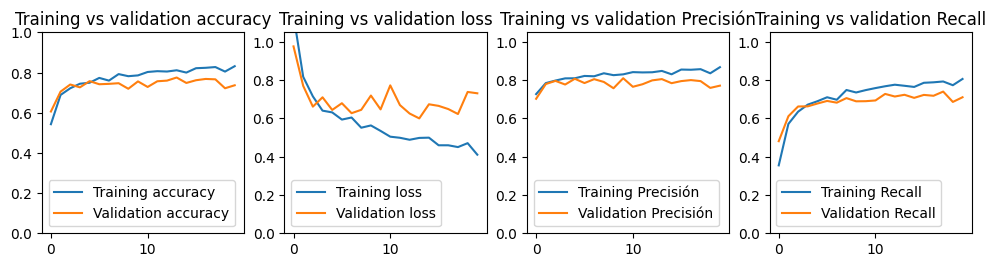

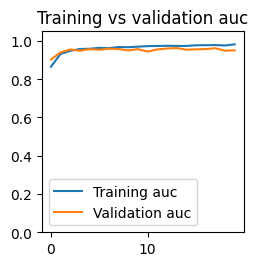

In [14]:
graph(history4)

In [15]:
y_pred4_test = model4.predict(test_generator)
y_pred4_val = model4.predict(validation_generator)

39/39 [==============================] - 13s 347ms/step


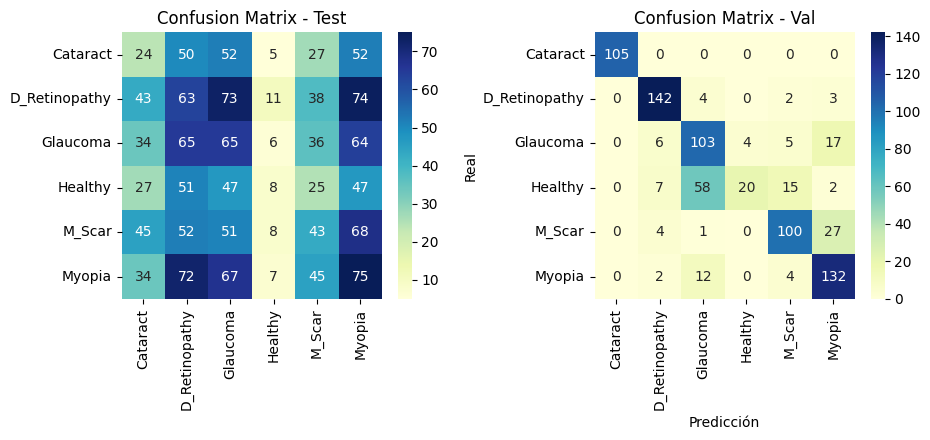

In [16]:
cf_matrix(y_pred4_test, test_generator.classes, y_pred4_val, validation_generator.classes)

In [18]:
reporte = calcular_metricas_por_clase(y_pred4_test, test_generator.classes)
print(reporte)
reporte = calcular_metricas_por_clase(y_pred4_val, validation_generator.classes)
print(reporte)

              precision    recall  f1-score   support

           0       0.12      0.11      0.12       210
           1       0.18      0.21      0.19       302
           2       0.18      0.24      0.21       270
           3       0.18      0.04      0.06       205
           4       0.20      0.16      0.18       267
           5       0.20      0.25      0.22       300

    accuracy                           0.18      1554
   macro avg       0.18      0.17      0.16      1554
weighted avg       0.18      0.18      0.17      1554

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       105
           1       0.88      0.94      0.91       151
           2       0.58      0.76      0.66       135
           3       0.83      0.20      0.32       102
           4       0.79      0.76      0.78       132
           5       0.73      0.88      0.80       150

    accuracy                           0.78       775
   macro avg       0.80

## Modelo 5

In [ ]:
# Cargar DenseNet201 sin la capa superior (top) para permitir una nueva capa de salida personalizada
base_model5 = DenseNet201(include_top=False, weights='imagenet', input_shape=(224, 224, 3))

# Congelar los pesos del modelo base para evitar que se modifiquen durante el entrenamiento inicial
for layer in base_model5.layers:
    layer.trainable = False

model5 = Sequential()
model5.add(base_model5)
model5.add(GlobalAveragePooling2D())
model5.add(Dense(2056, activation = 'relu'))
model5.add(Dense(1024, activation = 'relu'))
model5.add(Dense(512, activation = 'relu'))
model5.add(Dense(256, activation = 'relu'))
model5.add(Dense(6, activation='softmax'))

#opt = tf.keras.optimizers.Adam(learning_rate=0.0001)

# Compilar el modelo
model5.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', tf.keras.metrics.Precision(name="precision"), tf.keras.metrics.Recall(name="recall"), tf.keras.metrics.AUC(name="auc")])
callback = tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=4)

history5 = model5.fit(train_generator, validation_data=test_generator, steps_per_epoch = 100, epochs=20, callbacks=callback)

Epoch 1/20
100/100 [==============================] - 85s 703ms/step - loss: 1.2836 - accuracy: 0.4700 - precision: 0.7194 - recall: 0.2820 - auc: 0.8259 - val_loss: 1.0094 - val_accuracy: 0.6062 - val_precision: 0.8629 - val_recall: 0.3887 - val_auc: 0.8960
Epoch 2/20
100/100 [==============================] - 69s 694ms/step - loss: 0.8889 - accuracy: 0.6445 - precision: 0.7730 - recall: 0.4920 - auc: 0.9191 - val_loss: 0.8198 - val_accuracy: 0.6686 - val_precision: 0.8082 - val_recall: 0.5097 - val_auc: 0.9335
Epoch 3/20
100/100 [==============================] - 68s 681ms/step - loss: 0.7903 - accuracy: 0.6900 - precision: 0.7807 - recall: 0.5910 - auc: 0.9367 - val_loss: 0.9200 - val_accuracy: 0.6634 - val_precision: 0.7734 - val_recall: 0.5753 - val_auc: 0.9226
Epoch 4/20
100/100 [==============================] - 67s 674ms/step - loss: 0.7280 - accuracy: 0.7060 - precision: 0.7810 - recall: 0.6260 - auc: 0.9459 - val_loss: 0.7117 - val_accuracy: 0.7265 - val_precision: 0.7954 - v

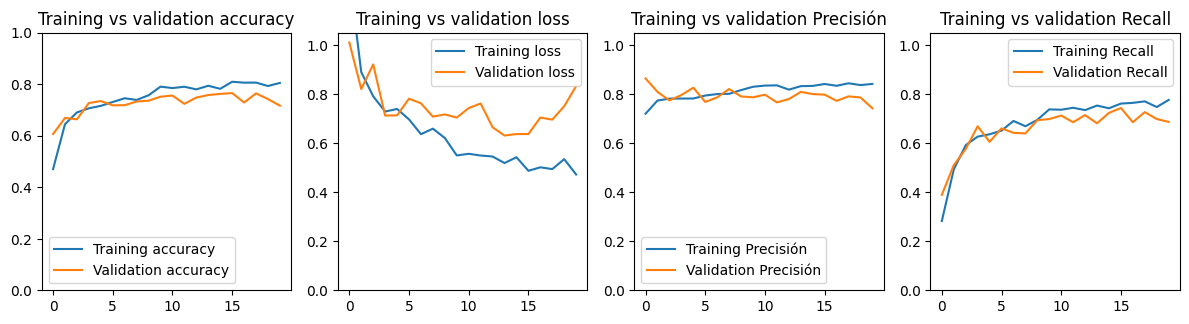

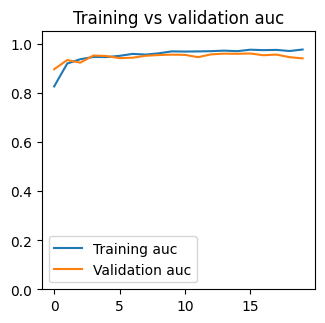

In [ ]:
graph(history5)

39/39 [==============================] - 18s 462ms/step


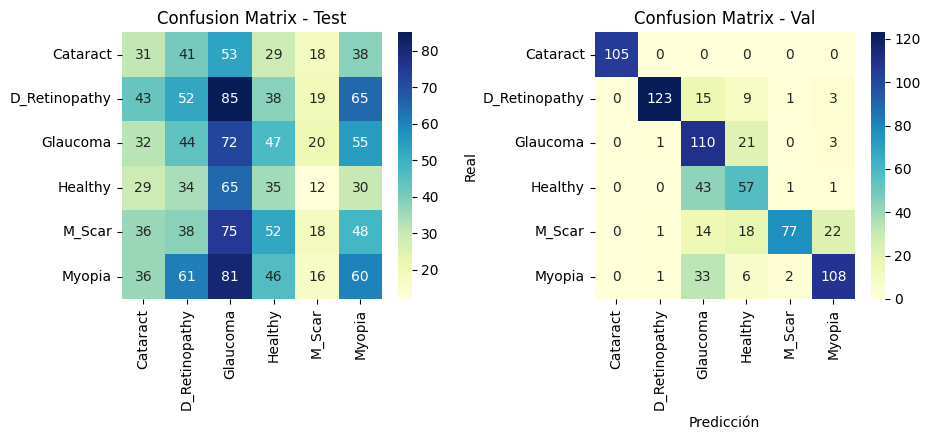

In [ ]:
y_pred5_test = model5.predict(test_generator)
y_pred5_val = model5.predict(validation_generator)
cf_matrix(y_pred5_test, test_generator.classes, y_pred5_val, validation_generator.classes)

In [ ]:
reporte = calcular_metricas_por_clase(y_pred5_test, test_generator.classes)
print(reporte)
reporte = calcular_metricas_por_clase(y_pred5_val, validation_generator.classes)
print(reporte)

              precision    recall  f1-score   support

           0       0.15      0.15      0.15       210
           1       0.19      0.17      0.18       302
           2       0.17      0.27      0.21       270
           3       0.14      0.17      0.15       205
           4       0.17      0.07      0.10       267
           5       0.20      0.20      0.20       300

    accuracy                           0.17      1554
   macro avg       0.17      0.17      0.16      1554
weighted avg       0.17      0.17      0.17      1554

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       105
           1       0.98      0.81      0.89       151
           2       0.51      0.81      0.63       135
           3       0.51      0.56      0.54       102
           4       0.95      0.58      0.72       132
           5       0.79      0.72      0.75       150

    accuracy                           0.75       775
   macro avg       0.79

## Modelo 15

In [ ]:
# Cargar DenseNet201 sin la capa superior (top) para permitir una nueva capa de salida personalizada
base_model15 = DenseNet201(include_top=False, weights='imagenet', input_shape=(224, 224, 3))

# Congelar los pesos del modelo base para evitar que se modifiquen durante el entrenamiento inicial
for layer in base_model15.layers:
    layer.trainable = False

model15 = Sequential()
model15.add(base_model15)
model15.add(GlobalAveragePooling2D())
model15.add(Dense(2056, activation = 'relu'))
model15.add(Dense(1024, activation = 'relu'))
model15.add(Dense(512, activation = 'relu'))
model15.add(Dense(256, activation = 'relu'))
model15.add(Dense(6, activation='softmax'))

opt = tf.keras.optimizers.Adam(learning_rate=0.0001)

# Compilar el modelo
model15.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy', tf.keras.metrics.Precision(name="precision"), tf.keras.metrics.Recall(name="recall"), tf.keras.metrics.AUC(name="auc")])
callback = tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=4)

history15 = model15.fit(train_generator, validation_data=test_generator, steps_per_epoch = 150, epochs=25, callbacks=callback)

Epoch 1/25
150/150 [==============================] - 116s 678ms/step - loss: 1.0420 - accuracy: 0.5829 - precision: 0.7715 - recall: 0.3961 - auc: 0.8873 - val_loss: 0.8243 - val_accuracy: 0.6628 - val_precision: 0.7805 - val_recall: 0.5470 - val_auc: 0.9317
Epoch 2/25
150/150 [==============================] - 107s 715ms/step - loss: 0.7300 - accuracy: 0.7070 - precision: 0.8001 - recall: 0.6057 - auc: 0.9464 - val_loss: 0.6729 - val_accuracy: 0.7272 - val_precision: 0.8147 - val_recall: 0.6422 - val_auc: 0.9541
Epoch 3/25
150/150 [==============================] - 107s 712ms/step - loss: 0.6519 - accuracy: 0.7366 - precision: 0.8112 - recall: 0.6604 - auc: 0.9569 - val_loss: 0.6358 - val_accuracy: 0.7497 - val_precision: 0.8099 - val_recall: 0.6744 - val_auc: 0.9590
Epoch 4/25
150/150 [==============================] - 96s 641ms/step - loss: 0.5807 - accuracy: 0.7690 - precision: 0.8287 - recall: 0.7097 - auc: 0.9656 - val_loss: 0.6366 - val_accuracy: 0.7625 - val_precision: 0.8003 

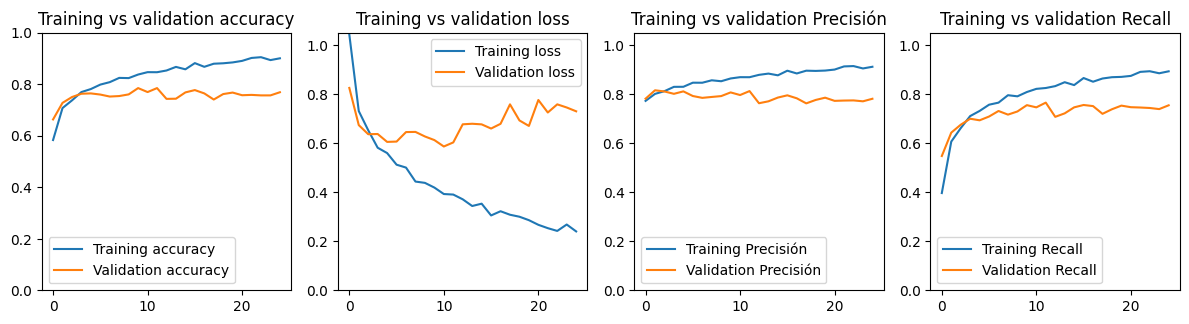

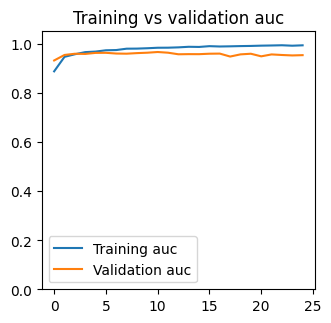

In [ ]:
graph(history15)

39/39 [==============================] - 17s 437ms/step


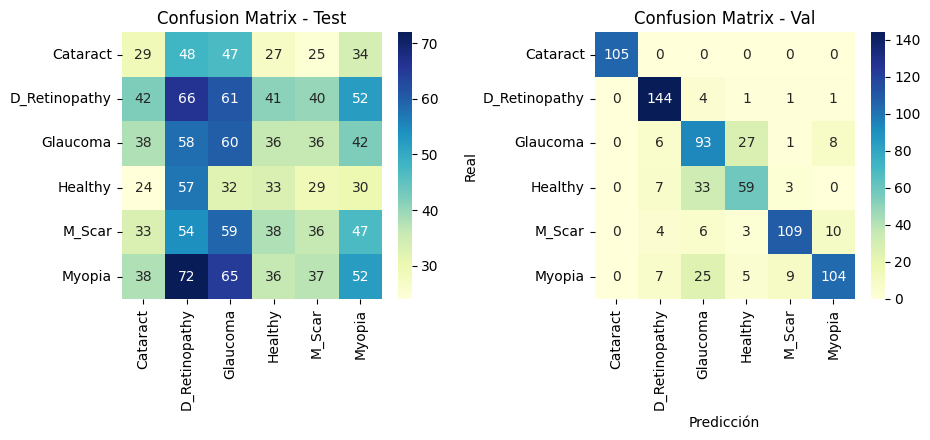

In [ ]:
y_pred15_test = model15.predict(test_generator)
y_pred15_val = model15.predict(validation_generator)
cf_matrix(y_pred15_test, test_generator.classes, y_pred15_val, validation_generator.classes)

In [ ]:
reporte = calcular_metricas_por_clase(y_pred15_test, test_generator.classes)
print(reporte)
reporte = calcular_metricas_por_clase(y_pred15_val, validation_generator.classes)
print(reporte)

              precision    recall  f1-score   support

           0       0.14      0.14      0.14       210
           1       0.19      0.22      0.20       302
           2       0.19      0.22      0.20       270
           3       0.16      0.16      0.16       205
           4       0.18      0.13      0.15       267
           5       0.20      0.17      0.19       300

    accuracy                           0.18      1554
   macro avg       0.17      0.17      0.17      1554
weighted avg       0.18      0.18      0.18      1554

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       105
           1       0.86      0.95      0.90       151
           2       0.58      0.69      0.63       135
           3       0.62      0.58      0.60       102
           4       0.89      0.83      0.85       132
           5       0.85      0.69      0.76       150

    accuracy                           0.79       775
   macro avg       0.80

## Modelo 16

In [ ]:
base_model16 = tf.keras.applications.DenseNet201(weights='imagenet', input_shape=input_shape, include_top=False)

for layer in base_model16.layers:
    layer.trainable = False


model16 = Sequential()
model16.add(base_model16)
model16.add(GlobalAveragePooling2D())
model16.add(Dense(2056, activation = 'relu'))
model16.add(Dropout(0.2))
model16.add(Dense(1024, activation = 'relu'))
model16.add(Dense(512, activation = 'relu'))
model16.add(Dropout(0.25))
model16.add(Dense(256, activation = 'relu'))
model16.add(Dense(6, activation='softmax'))
model16.summary()

opt = tf.keras.optimizers.Adam(learning_rate=0.0001)

model16.compile(optimizer=opt, loss='categorical_crossentropy', metrics=["accuracy", tf.keras.metrics.Precision(name="precision"), tf.keras.metrics.Recall(name="recall"), tf.keras.metrics.AUC(name="auc")])
callback = tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=4)

history16 = model16.fit(train_generator, validation_data=test_generator, steps_per_epoch = 150, epochs=25, callbacks=callback)

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet201 (Functional)    (None, 7, 7, 1920)        18321984  
                                                                 
 global_average_pooling2d_5  (None, 1920)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_15 (Dense)            (None, 2056)              3949576   
                                                                 
 dropout (Dropout)           (None, 2056)              0         
                                                                 
 dense_16 (Dense)            (None, 1024)              2106368   
                                                                 
 dense_17 (Dense)            (None, 512)               524800    
                                                      

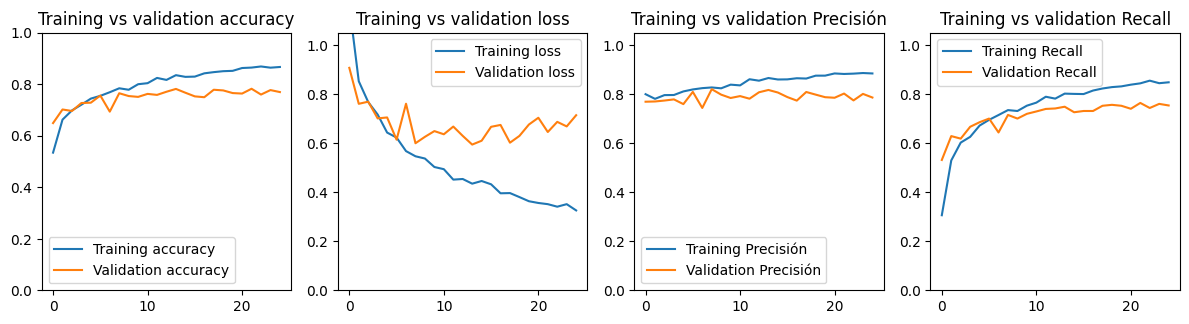

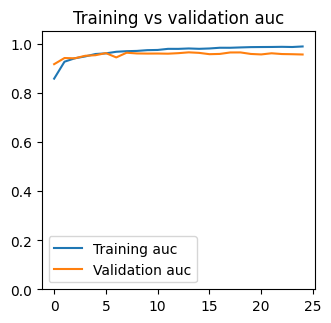

In [ ]:
graph(history16)

39/39 [==============================] - 14s 368ms/step


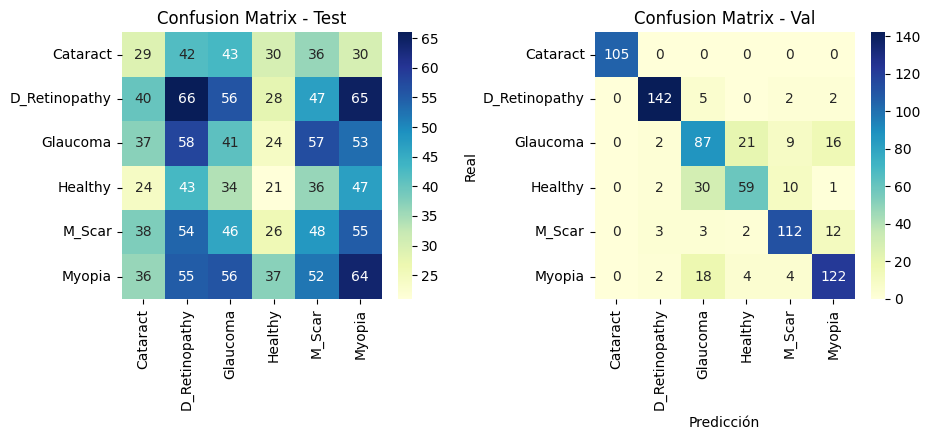

In [ ]:
y_pred16_test = model16.predict(test_generator)
y_pred16_val = model16.predict(validation_generator)
cf_matrix(y_pred16_test, test_generator.classes, y_pred16_val, validation_generator.classes)

In [ ]:
reporte = calcular_metricas_por_clase(y_pred16_test, test_generator.classes)
print(reporte)
reporte = calcular_metricas_por_clase(y_pred16_val, validation_generator.classes)
print(reporte)

              precision    recall  f1-score   support

           0       0.14      0.14      0.14       210
           1       0.21      0.22      0.21       302
           2       0.15      0.15      0.15       270
           3       0.13      0.10      0.11       205
           4       0.17      0.18      0.18       267
           5       0.20      0.21      0.21       300

    accuracy                           0.17      1554
   macro avg       0.17      0.17      0.17      1554
weighted avg       0.17      0.17      0.17      1554

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       105
           1       0.94      0.94      0.94       151
           2       0.61      0.64      0.63       135
           3       0.69      0.58      0.63       102
           4       0.82      0.85      0.83       132
           5       0.80      0.81      0.81       150

    accuracy                           0.81       775
   macro avg       0.81

## Modelo 6

In [11]:
base_model6 = tf.keras.applications.DenseNet201(weights='imagenet', input_shape=input_shape, include_top=False)

for layer in base_model6.layers:
    layer.trainable = False


model6 = Sequential()
model6.add(base_model6)
model6.add(GlobalAveragePooling2D())
model6.add(Dense(5112, activation = 'relu'))
model6.add(Dense(2056, activation = 'relu'))
model6.add(Dense(1024, activation = 'relu'))
model6.add(Dense(512, activation = 'relu'))
model6.add(Dense(256, activation = 'relu'))
model6.add(Dense(128, activation = 'relu'))
model6.add(Dense(6, activation='softmax'))
model6.summary()

model6.compile(optimizer="adam", loss='categorical_crossentropy', metrics=["accuracy", tf.keras.metrics.Precision(name="precision"), tf.keras.metrics.Recall(name="recall"), tf.keras.metrics.AUC(name="auc")])
callback = tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=4)

history6 = model6.fit(train_generator, validation_data=test_generator, steps_per_epoch = 150, epochs=30, callbacks=callback)

74836368/74836368 [==============================] - 5s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet201 (Functional)    (None, 7, 7, 1920)        18321984  
                                                                 
 global_average_pooling2d (  (None, 1920)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 5112)              9820152   
                                                                 
 dense_1 (Dense)             (None, 2056)              10512328  
                                                                 
 dense_2 (Dense)             (None, 1024)              2106368   
                                                                 
 dense_3 (Dense)             (None, 512)               52

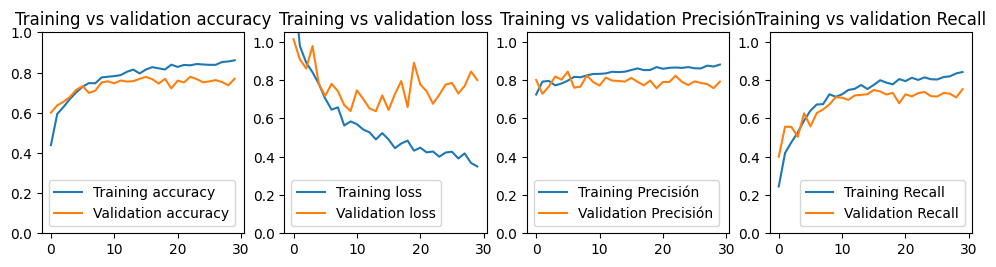

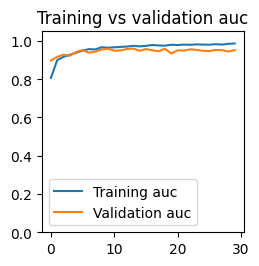

In [12]:
graph(history6)

In [13]:
y_pred6_test = model6.predict(test_generator)
y_pred6_val = model6.predict(validation_generator)

39/39 [==============================] - 13s 340ms/step


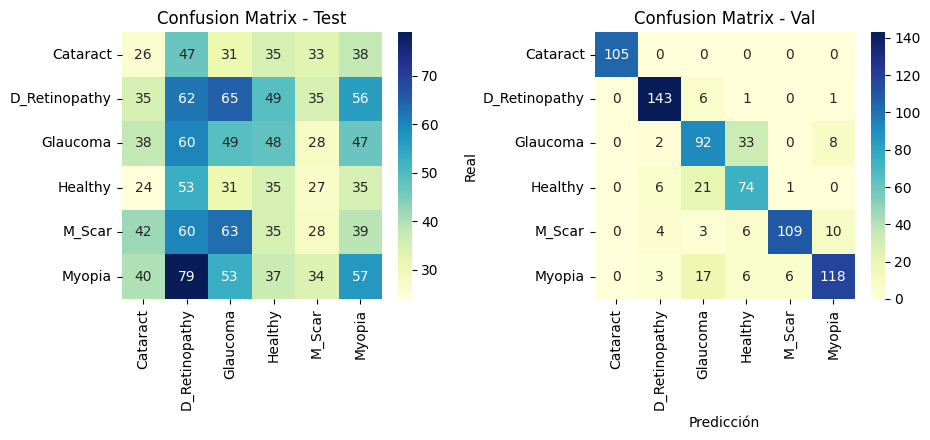

In [14]:
cf_matrix(y_pred6_test, test_generator.classes, y_pred6_val, validation_generator.classes)

In [16]:
reporte = calcular_metricas_por_clase(y_pred6_test, test_generator.classes)
print(reporte)
reporte = calcular_metricas_por_clase(y_pred6_val, validation_generator.classes)
print(reporte)

              precision    recall  f1-score   support

           0       0.13      0.12      0.13       210
           1       0.17      0.21      0.19       302
           2       0.17      0.18      0.17       270
           3       0.15      0.17      0.16       205
           4       0.15      0.10      0.12       267
           5       0.21      0.19      0.20       300

    accuracy                           0.17      1554
   macro avg       0.16      0.16      0.16      1554
weighted avg       0.17      0.17      0.16      1554

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       105
           1       0.91      0.95      0.93       151
           2       0.66      0.68      0.67       135
           3       0.62      0.73      0.67       102
           4       0.94      0.83      0.88       132
           5       0.86      0.79      0.82       150

    accuracy                           0.83       775
   macro avg       0.83

## Modelo 20

In [ ]:
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D

# Cargar DenseNet201 sin la capa superior (top) para permitir una nueva capa de salida personalizada
base_model20 = DenseNet201(include_top=False, weights='imagenet', input_shape=(224, 224, 3))

# Congelar los pesos del modelo base para evitar que se modifiquen durante el entrenamiento inicial
for layer in base_model20.layers:
    layer.trainable = False

# Añadir nuevas capas
x = GlobalAveragePooling2D()(base_model20.output)
x = Dense(512, activation='relu')(x)  # Añade una capa densa con 512 neuronas
predictions = Dense(6, activation='softmax')(x)  # Capa de salida para 10 clases

# Crear el modelo final
model20 = Model(inputs=base_model20.input, outputs=predictions)

# Compilar el modelo
model20.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy',  metrics=["accuracy", tf.keras.metrics.Precision(name="precision"), tf.keras.metrics.Recall(name="recall"), tf.keras.metrics.AUC(name="auc")])

# Imprimir un resumen del modelo
model20.summary()

callback = tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=4)
history_dense = model20.fit(train_generator, validation_data=test_generator, steps_per_epoch = 100, epochs=20, callbacks=callback)

74836368/74836368 [==============================] - 2s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 zero_padding2d (ZeroPaddin  (None, 230, 230, 3)          0         ['input_1[0][0]']             
 g2D)                                                                                             
                                                                                                  
 conv1/conv (Conv2D)         (None, 112, 112, 64)         9408      ['zero_padding2d[0][0]']      
                                                                                                  
 conv1/bn (BatchNormalizati  

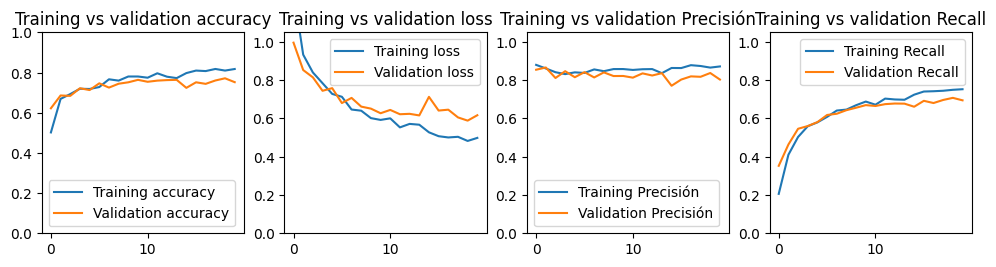

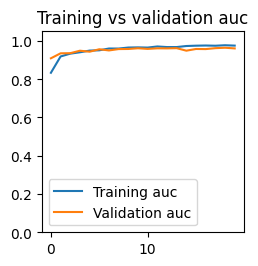

In [ ]:
graph(history_dense)

39/39 [==============================] - 21s 552ms/step


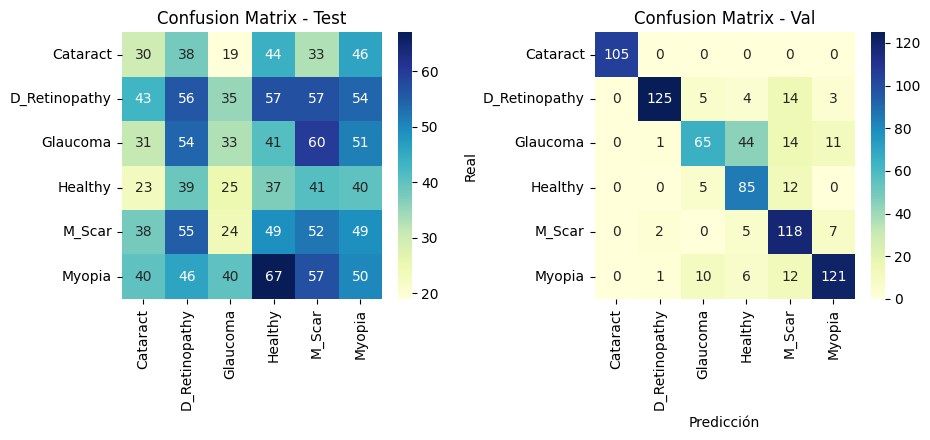

In [ ]:
y_pred_test = model20.predict(test_generator)
y_pred_val = model20.predict(validation_generator)
cf_matrix(y_pred_test, test_generator.classes, y_pred_val, validation_generator.classes)

In [ ]:
reporte = calcular_metricas_por_clase(y_pred_test, test_generator.classes)
print(reporte)
reporte = calcular_metricas_por_clase(y_pred_val, validation_generator.classes)
print(reporte)

              precision    recall  f1-score   support

           0       0.15      0.14      0.14       210
           1       0.19      0.19      0.19       302
           2       0.19      0.12      0.15       270
           3       0.13      0.18      0.15       205
           4       0.17      0.19      0.18       267
           5       0.17      0.17      0.17       300

    accuracy                           0.17      1554
   macro avg       0.17      0.17      0.16      1554
weighted avg       0.17      0.17      0.17      1554

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       105
           1       0.97      0.83      0.89       151
           2       0.76      0.48      0.59       135
           3       0.59      0.83      0.69       102
           4       0.69      0.89      0.78       132
           5       0.85      0.81      0.83       150

    accuracy                           0.80       775
   macro avg       0.81

## Modelo 19

In [ ]:
# Cargar DenseNet201 sin la capa superior (top) para permitir una nueva capa de salida personalizada
base_model19 = DenseNet201(include_top=False, weights='imagenet', input_shape=(224, 224, 3))

# Congelar los pesos del modelo base para evitar que se modifiquen durante el entrenamiento inicial
for layer in base_model19.layers:
    layer.trainable = False

model19 = Sequential()
model19.add(base_model19)
model19.add(GlobalAveragePooling2D())
model19.add(Dense(2056, activation = 'relu'))
model19.add(Dropout(0.75))
model19.add(Dense(1024, activation = 'relu'))
model19.add(Dense(512, activation = 'relu'))
model19.add(Dropout(0.15))
model19.add(Dense(256, activation = 'relu'))
model19.add(Dense(128, activation = 'relu'))
model19.add(Dense(6, activation='softmax'))

opt = tf.keras.optimizers.Adam(learning_rate=0.0001)

# Compilar el modelo
model19.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy', tf.keras.metrics.Precision(name="precision"), tf.keras.metrics.Recall(name="recall"), tf.keras.metrics.AUC(name="auc")])
callback = tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=4)

history19 = model19.fit(train_generator, validation_data=test_generator, steps_per_epoch = 150, epochs=25, callbacks=callback)

Epoch 1/25
150/150 [==============================] - 100s 587ms/step - loss: 1.5202 - accuracy: 0.3419 - precision: 0.8000 - recall: 0.0949 - auc: 0.7251 - val_loss: 1.1553 - val_accuracy: 0.4968 - val_precision: 0.7750 - val_recall: 0.2548 - val_auc: 0.8609
Epoch 2/25
150/150 [==============================] - 88s 585ms/step - loss: 1.1827 - accuracy: 0.5191 - precision: 0.7367 - recall: 0.2787 - auc: 0.8503 - val_loss: 0.9539 - val_accuracy: 0.6384 - val_precision: 0.8489 - val_recall: 0.3797 - val_auc: 0.9113
Epoch 3/25
150/150 [==============================] - 89s 594ms/step - loss: 1.0519 - accuracy: 0.5712 - precision: 0.7502 - recall: 0.3783 - auc: 0.8847 - val_loss: 0.8409 - val_accuracy: 0.6821 - val_precision: 0.8564 - val_recall: 0.4453 - val_auc: 0.9328
Epoch 4/25
150/150 [==============================] - 87s 578ms/step - loss: 0.9684 - accuracy: 0.6050 - precision: 0.7631 - recall: 0.4380 - auc: 0.9034 - val_loss: 0.7961 - val_accuracy: 0.6828 - val_precision: 0.8173 - 

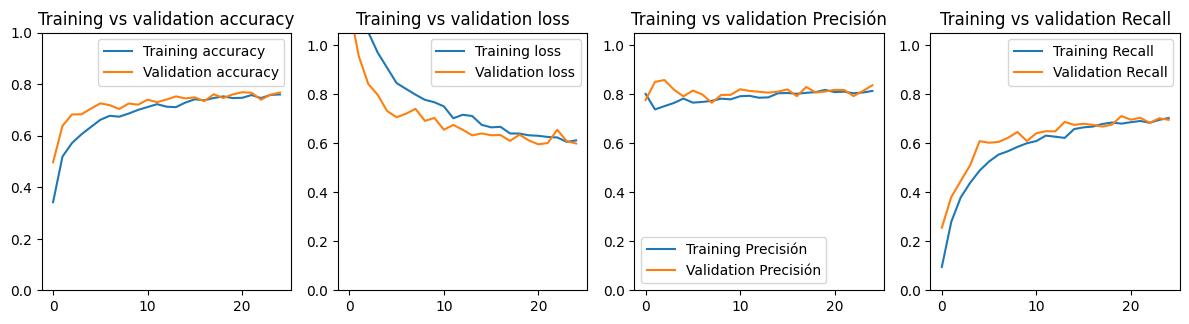

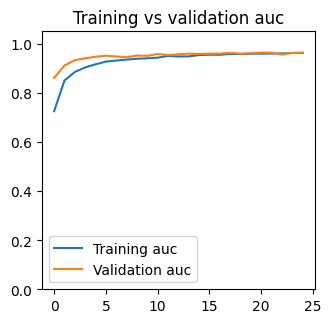

In [ ]:
graph(history19)

39/39 [==============================] - 14s 371ms/step


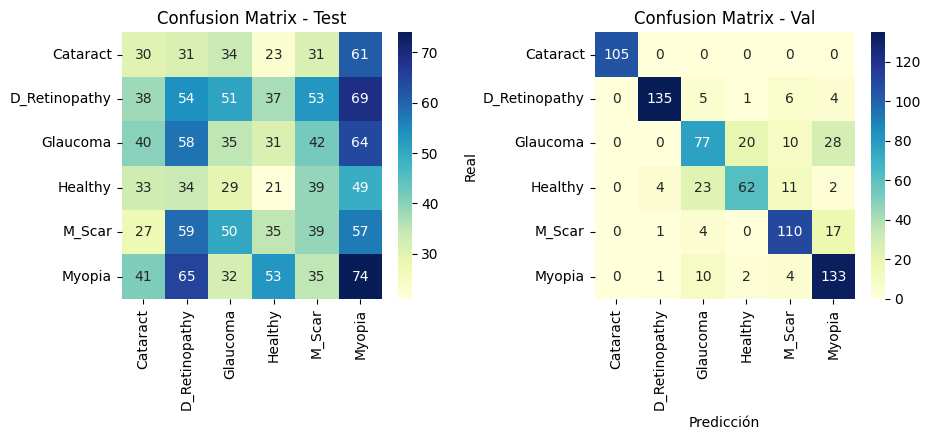

In [ ]:
y_pred19_test = model19.predict(test_generator)
y_pred19_val = model19.predict(validation_generator)
cf_matrix(y_pred19_test, test_generator.classes, y_pred19_val, validation_generator.classes)

In [ ]:
reporte = calcular_metricas_por_clase(y_pred19_test, test_generator.classes)
print(reporte)
reporte = calcular_metricas_por_clase(y_pred19_val, validation_generator.classes)
print(reporte)

              precision    recall  f1-score   support

           0       0.14      0.14      0.14       210
           1       0.18      0.18      0.18       302
           2       0.15      0.13      0.14       270
           3       0.10      0.10      0.10       205
           4       0.16      0.15      0.15       267
           5       0.20      0.25      0.22       300

    accuracy                           0.16      1554
   macro avg       0.16      0.16      0.16      1554
weighted avg       0.16      0.16      0.16      1554

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       105
           1       0.96      0.89      0.92       151
           2       0.65      0.57      0.61       135
           3       0.73      0.61      0.66       102
           4       0.78      0.83      0.81       132
           5       0.72      0.89      0.80       150

    accuracy                           0.80       775
   macro avg       0.81

# Evaluación

Para todos los modelos utilizados se evalua su capacidad de predicción para Entrenamiento, Validación y Prueba

In [ ]:
evaluar_modelo(model1)

Evaluar con Entrenamiento:
272/272 [==============================] - 101s 372ms/step - loss: 0.4428 - accuracy: 0.8201 - precision: 0.8509 - recall: 0.7872 - auc: 0.9793
Evaluar con Validación:
78/78 [==============================] - 31s 394ms/step - loss: 0.6745 - accuracy: 0.7484 - precision: 0.7827 - recall: 0.7207 - auc: 0.9563
Evaluar con Prueba:
39/39 [==============================] - 15s 393ms/step - loss: 0.5076 - accuracy: 0.7935 - precision: 0.8220 - recall: 0.7510 - auc: 0.9726


In [19]:
evaluar_modelo(model4)

Evaluar con Entrenamiento:
272/272 [==============================] - 94s 345ms/step - loss: 0.5030 - accuracy: 0.8017 - precision: 0.8338 - recall: 0.7758 - auc: 0.9746
Evaluar con Validación:
78/78 [==============================] - 27s 346ms/step - loss: 0.7317 - accuracy: 0.7368 - precision: 0.7716 - recall: 0.7111 - auc: 0.9512
Evaluar con Prueba:
39/39 [==============================] - 13s 346ms/step - loss: 0.5998 - accuracy: 0.7768 - precision: 0.8030 - recall: 0.7523 - auc: 0.9666


In [ ]:
evaluar_modelo(model5)

Evaluar con Entrenamiento:
272/272 [==============================] - 114s 417ms/step - loss: 0.5922 - accuracy: 0.7680 - precision: 0.8001 - recall: 0.7421 - auc: 0.9652
Evaluar con Validación:
78/78 [==============================] - 34s 435ms/step - loss: 0.8320 - accuracy: 0.7162 - precision: 0.7413 - recall: 0.6860 - auc: 0.9402
Evaluar con Prueba:
39/39 [==============================] - 19s 488ms/step - loss: 0.6357 - accuracy: 0.7484 - precision: 0.7762 - recall: 0.7161 - auc: 0.9598


In [ ]:
evaluar_modelo(model15)

Evaluar con Entrenamiento:
272/272 [==============================] - 112s 410ms/step - loss: 0.2232 - accuracy: 0.9151 - precision: 0.9266 - recall: 0.9035 - auc: 0.9949
Evaluar con Validación:
78/78 [==============================] - 30s 378ms/step - loss: 0.7291 - accuracy: 0.7683 - precision: 0.7801 - recall: 0.7535 - auc: 0.9533
Evaluar con Prueba:
39/39 [==============================] - 14s 372ms/step - loss: 0.5366 - accuracy: 0.7923 - precision: 0.8037 - recall: 0.7819 - auc: 0.9732


In [ ]:
evaluar_modelo(model16)

Evaluar con Entrenamiento:
272/272 [==============================] - 101s 371ms/step - loss: 0.2581 - accuracy: 0.8978 - precision: 0.9095 - recall: 0.8842 - auc: 0.9929
Evaluar con Validación:
78/78 [==============================] - 29s 368ms/step - loss: 0.7132 - accuracy: 0.7690 - precision: 0.7852 - recall: 0.7529 - auc: 0.9560
Evaluar con Prueba:
39/39 [==============================] - 15s 389ms/step - loss: 0.5326 - accuracy: 0.8090 - precision: 0.8289 - recall: 0.8000 - auc: 0.9710


In [17]:
evaluar_modelo(model6)

Evaluar con Entrenamiento:
272/272 [==============================] - 87s 320ms/step - loss: 0.3563 - accuracy: 0.8643 - precision: 0.8807 - recall: 0.8481 - auc: 0.9860
Evaluar con Validación:
78/78 [==============================] - 24s 312ms/step - loss: 0.8010 - accuracy: 0.7696 - precision: 0.7932 - recall: 0.7529 - auc: 0.9524
Evaluar con Prueba:
39/39 [==============================] - 12s 322ms/step - loss: 0.4808 - accuracy: 0.8271 - precision: 0.8400 - recall: 0.8129 - auc: 0.9754


In [ ]:
evaluar_modelo(model19)

Evaluar con Entrenamiento:
272/272 [==============================] - 102s 376ms/step - loss: 0.4911 - accuracy: 0.8154 - precision: 0.8812 - recall: 0.7320 - auc: 0.9777
Evaluar con Validación:
78/78 [==============================] - 28s 364ms/step - loss: 0.5980 - accuracy: 0.7671 - precision: 0.8351 - recall: 0.6943 - auc: 0.9637
Evaluar con Prueba:
39/39 [==============================] - 15s 381ms/step - loss: 0.4950 - accuracy: 0.8026 - precision: 0.8717 - recall: 0.7277 - auc: 0.9763


In [ ]:
evaluar_modelo(model20)

Evaluar con Entrenamiento:
272/272 [==============================] - 100s 367ms/step - loss: 0.4950 - accuracy: 0.8069 - precision: 0.8603 - recall: 0.7483 - auc: 0.9761
Evaluar con Validación:
78/78 [==============================] - 31s 403ms/step - loss: 0.6170 - accuracy: 0.7523 - precision: 0.8036 - recall: 0.6950 - auc: 0.9611
Evaluar con Prueba:
39/39 [==============================] - 17s 442ms/step - loss: 0.5295 - accuracy: 0.7987 - precision: 0.8534 - recall: 0.7510 - auc: 0.9717
